<a href="https://colab.research.google.com/github/Denchil-RPG/Machine/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Автокодировщик имеет ту же архитектуру, что и обычный MLP (многослойный перцептрон), за исключением требования, чтобы количество входных нейронов было равно количеству нейронов в выходном слое. Автокодировщик во время обучения выучивает внутренние представления данных так, чтобы по входу можно было реконструировать выход. Таким образом, это означает, что автокодировщик не может просто копировать ввод в вывод, он вынужден изучать наиболее важные признаки ввода и отбрасывать остальные.

Как мы можем использовать автокодировщик для обнаружения мошеннических транзакций? Автокодировщиком мы пытаемся оптимизировать модель (то есть параметры модели), чтобы минимизировать ошибку реконструкции.

Теперь предположим, что мы подаем цифру 5 и на выходе получаем восстановленную цифру 5 с минимальной ошибкой восстановления. Теперь попробуем скормить другую цифру, которая пытается имитировать 5, когда мы получим на выходах ее восстановленную версию, она будет с большой ошибкой реконструкции. Это логика использования автокодировщика для обнаружения мошенничества. На вход подаем вектор из признаков (30 признаков).

In [1]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]
df = pd.read_csv('transaction_dataset.csv')

In [2]:
df

,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,9836,2175,0xff481ca14e6c16b79fc8ab299b4d2387ec8ecdd2,1,12635.10,631.39,58748.48,4,13,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,2.0,,GSENetwork
9837,9837,2176,0xff718805bb9199ebf024ab6acd333e603ad77c85,1,0.00,0.00,0.00,0,0,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU
9838,9838,2177,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,1,2499.44,2189.29,261601.88,67,43,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,5.0,,Free BOB Tokens - BobsRepair.com
9839,9839,2178,0xffde23396d57e10abf58bd929bb1e856c7718218,1,0.00,0.00,0.00,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 51 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Unnamed: 0                                            9841 non-null   int64  
 1   Index                                                 9841 non-null   int64  
 2   Address                                               9841 non-null   object 
 3   FLAG                                                  9841 non-null   int64  
 4   Avg min between sent tnx                              9841 non-null   float64
 5   Avg min between received tnx                          9841 non-null   float64
 6   Time Diff between first and last (Mins)               9841 non-null   float64
 7   Sent tnx                                              9841 non-null   int64  
 8   Received Tnx                                          9841

In [4]:
total_transactions = len(df)
normal_transactions = len(df[df['FLAG'] == 0])
fraudulent_transactions = len(df[df['FLAG'] == 1])

normal_percentage = (normal_transactions / total_transactions) * 100
fraudulent_percentage = (fraudulent_transactions / total_transactions) * 100

print(f'Total: {total_transactions}')
print(f'Normal: {normal_transactions}')
print(f'Fraud: {fraudulent_transactions}')
print(f'Обычные: {normal_percentage:.4f}%')
print(f'Мошеннические: {fraudulent_percentage:.4f}%')

Total: 9841
Normal: 7662
Fraud: 2179
Обычные: 77.8579%
Мошеннические: 22.1421%


In [5]:
num_col = []
cat_col = []

# Перебираем все столбцы и добавляем их в соответствующие списки
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:  # Проверяем тип данных для числовых столбцов
        num_col.append(col)
    else:
        cat_col.append(col)

print("Числовые столбцы:", num_col)
print("Категориальные столбцы:", cat_col)

Числовые столбцы: ['Unnamed: 0', 'Index', 'FLAG', 'Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Number of Created Contracts', 'Unique Received From Addresses', 'Unique Sent To Addresses', 'min value received', 'max value received ', 'avg val received', 'min val sent', 'max val sent', 'avg val sent', 'min value sent to contract', 'max val sent to contract', 'avg value sent to contract', 'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received', 'total ether sent contracts', 'total ether balance', ' Total ERC20 tnxs', ' ERC20 total Ether received', ' ERC20 total ether sent', ' ERC20 total Ether sent contract', ' ERC20 uniq sent addr', ' ERC20 uniq rec addr', ' ERC20 uniq sent addr.1', ' ERC20 uniq rec contract addr', ' ERC20 avg time between sent tnx', ' ERC20 avg time between rec tnx', ' ERC20 avg time between rec 2 tnx', ' ERC20 avg time between contract tnx', 

In [6]:
df_filtered = df.copy()

In [7]:

df_filtered.drop(columns=['Unnamed: 0'], inplace=True)
df_filtered.drop(columns=['Index'], inplace=True)

num_col.remove('Unnamed: 0')
num_col.remove('Index')

In [8]:
df_filtered.isnull().sum()

,0
Address,0
FLAG,0
Avg min between sent tnx,0
Avg min between received tnx,0
Time Diff between first and last (Mins),0
Sent tnx,0
Received Tnx,0
Number of Created Contracts,0
Unique Received From Addresses,0
Unique Sent To Addresses,0


Проверим наблюдения, по которым нет данных по большинству параметров

Видим, что одни и те же строки (829) имеют пропуски по большинству показателей

Заметили, что все эти операции (с пропущенными значениями) являются мошенническими

Это 829 / 2179 = 0.38 от всех мошеннических!

Нельзя удалять

Это важная информация!

Добавим к данным индикатор (если пропусков больше 20, то 1, иначе 0)

In [9]:
df_filtered['indicator_many_nan'] = df_filtered.isna().sum(axis=1).apply(lambda x: 1 if x > 10 else 0)
cat_col.append('indicator_many_nan')

In [10]:
df_filtered

,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,...,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type,indicator_many_nan
0,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,118,...,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire,0
1,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,14,...,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token,0
2,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,2,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON,0
3,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,13,...,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON,0
4,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,19,...,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,0xff481ca14e6c16b79fc8ab299b4d2387ec8ecdd2,1,12635.10,631.39,58748.48,4,13,0,11,4,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,2.0,,GSENetwork,0
9837,0xff718805bb9199ebf024ab6acd333e603ad77c85,1,0.00,0.00,0.00,0,0,0,0,0,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU,0
9838,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,1,2499.44,2189.29,261601.88,67,43,0,31,44,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,5.0,,Free BOB Tokens - BobsRepair.com,0
9839,0xffde23396d57e10abf58bd929bb1e856c7718218,1,0.00,0.00,0.00,0,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


Пропуски в этих строках заполним медианой по известным мошенническим операциям

In [11]:
fraud_df = df_filtered[df_filtered['FLAG'] == 1]
fraud_df

,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,...,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type,indicator_many_nan
7662,0x0020731604c882cf7bf8c444be97d17b19ea4316,1,1457.31,34.12,4815.43,3,13,0,10,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
7663,0x002bf459dc58584d58886169ea0e80f3ca95ffaf,1,3976.50,834.77,9622.53,2,2,0,1,2,...,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU,0
7664,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,1,112.90,31.87,321.42,2,3,0,3,1,...,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU,0
7665,0x0059b14e35dab1b4eee1e2926c7a5660da66f747,1,2300.37,65.10,73091.00,29,98,0,89,26,...,81324.0746,5232.816018,0.0,0.0,0.0,22.0,37.0,OCoin,OCoin,0
7666,0x005b9f4516f8e640bbe48136901738b323c53b00,1,0.00,0.00,0.00,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,0xff481ca14e6c16b79fc8ab299b4d2387ec8ecdd2,1,12635.10,631.39,58748.48,4,13,0,11,4,...,0.0000,0.000000,0.0,0.0,0.0,0.0,2.0,,GSENetwork,0
9837,0xff718805bb9199ebf024ab6acd333e603ad77c85,1,0.00,0.00,0.00,0,0,0,0,0,...,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU,0
9838,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,1,2499.44,2189.29,261601.88,67,43,0,31,44,...,0.0000,0.000000,0.0,0.0,0.0,0.0,5.0,,Free BOB Tokens - BobsRepair.com,0
9839,0xffde23396d57e10abf58bd929bb1e856c7718218,1,0.00,0.00,0.00,0,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [12]:
# Выбор колонок
missing_829_counts = df_filtered.isnull().sum()
columns_829_missing = missing_829_counts[missing_829_counts == 829].index.tolist()
columns_829_missing

[' Total ERC20 tnxs',
 ' ERC20 total Ether received',
 ' ERC20 total ether sent',
 ' ERC20 total Ether sent contract',
 ' ERC20 uniq sent addr',
 ' ERC20 uniq rec addr',
 ' ERC20 uniq sent addr.1',
 ' ERC20 uniq rec contract addr',
 ' ERC20 avg time between sent tnx',
 ' ERC20 avg time between rec tnx',
 ' ERC20 avg time between rec 2 tnx',
 ' ERC20 avg time between contract tnx',
 ' ERC20 min val rec',
 ' ERC20 max val rec',
 ' ERC20 avg val rec',
 ' ERC20 min val sent',
 ' ERC20 max val sent',
 ' ERC20 avg val sent',
 ' ERC20 min val sent contract',
 ' ERC20 max val sent contract',
 ' ERC20 avg val sent contract',
 ' ERC20 uniq sent token name',
 ' ERC20 uniq rec token name']

In [13]:
for column in columns_829_missing:
    # Проверяем тип данных столбца
    if df_filtered[column].dtype in ['float64', 'int64']:  # Числовые столбцы
      # Считаем медиану
      median_value = fraud_df[column].median()
      df_filtered[column].fillna(median_value, inplace=True)

    elif df_filtered[column].dtype == 'object':  # Текстовые столбцы
      # Считаем моду
      mode_value = fraud_df[column].mode()[0]
      df_filtered[column].fillna(mode_value, inplace=True)

<ipython-input-13-5feb9afbf2f2>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered[column].fillna(median_value, inplace=True)


In [14]:
df_filtered

,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,...,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type,indicator_many_nan
0,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,118,...,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire,0
1,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,14,...,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token,0
2,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,2,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON,0
3,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,13,...,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON,0
4,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,19,...,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,0xff481ca14e6c16b79fc8ab299b4d2387ec8ecdd2,1,12635.10,631.39,58748.48,4,13,0,11,4,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,2.0,,GSENetwork,0
9837,0xff718805bb9199ebf024ab6acd333e603ad77c85,1,0.00,0.00,0.00,0,0,0,0,0,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU,0
9838,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,1,2499.44,2189.29,261601.88,67,43,0,31,44,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,5.0,,Free BOB Tokens - BobsRepair.com,0
9839,0xffde23396d57e10abf58bd929bb1e856c7718218,1,0.00,0.00,0.00,0,1,0,1,0,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,1.0,NaN,NaN,1


In [15]:
df_filtered.isnull().sum()

,0
Address,0
FLAG,0
Avg min between sent tnx,0
Avg min between received tnx,0
Time Diff between first and last (Mins),0
Sent tnx,0
Received Tnx,0
Number of Created Contracts,0
Unique Received From Addresses,0
Unique Sent To Addresses,0


In [16]:
missing_token_type = df_filtered[df_filtered[' ERC20 most sent token type'].isnull()]
# Считаем количество 0 и 1 в столбце 'FLAG' для этих строк
flag_counts = missing_token_type['FLAG'].value_counts()
print(flag_counts)

FLAG
0    1868
1     829
Name: count, dtype: int64


In [17]:
missing_token_type = df_filtered[df_filtered[' ERC20_most_rec_token_type'].isnull()]
# Считаем количество 0 и 1 в столбце 'FLAG' для этих строк
flag_counts = missing_token_type['FLAG'].value_counts()
print(flag_counts)

FLAG
1    829
0     42
Name: count, dtype: int64


Те же 829 наблюдений, заполняем модой из мошеннических

In [18]:
list_fraud_non = [' ERC20 most sent token type', ' ERC20_most_rec_token_type']

for column in list_fraud_non:
    # Считаем моду для этого столбца в fraud_df
    mode_value = fraud_df[column].mode()[0]
    # Фильтруем строки, где FLAG == 1, и в которых есть пропуски в текущем столбце
    mask = (df_filtered['FLAG'] == 1) & (df_filtered[column].isnull())
    # Заполняем пропуски в столбце модой только для строк с FLAG == 1
    df_filtered.loc[mask, column] = mode_value

In [19]:
df_filtered

,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,...,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type,indicator_many_nan
0,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,118,...,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire,0
1,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,14,...,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token,0
2,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,2,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON,0
3,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,13,...,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON,0
4,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,19,...,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,0xff481ca14e6c16b79fc8ab299b4d2387ec8ecdd2,1,12635.10,631.39,58748.48,4,13,0,11,4,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,2.0,,GSENetwork,0
9837,0xff718805bb9199ebf024ab6acd333e603ad77c85,1,0.00,0.00,0.00,0,0,0,0,0,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU,0
9838,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,1,2499.44,2189.29,261601.88,67,43,0,31,44,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,5.0,,Free BOB Tokens - BobsRepair.com,0
9839,0xffde23396d57e10abf58bd929bb1e856c7718218,1,0.00,0.00,0.00,0,1,0,1,0,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU,1


In [20]:
df_filtered.isnull().sum()

,0
Address,0
FLAG,0
Avg min between sent tnx,0
Avg min between received tnx,0
Time Diff between first and last (Mins),0
Sent tnx,0
Received Tnx,0
Number of Created Contracts,0
Unique Received From Addresses,0
Unique Sent To Addresses,0


Заполняем пропуски в модами по немошенническим

In [21]:
norm_df = df_filtered[df_filtered['FLAG'] == 0]
list_fraud_non = [' ERC20 most sent token type', ' ERC20_most_rec_token_type']

for column in list_fraud_non:
    # Считаем моду для этого столбца в fraud_df
    mode_value = fraud_df[column].mode()[0]
    # Фильтруем строки, где FLAG == 0, и в которых есть пропуски в текущем столбце
    mask = (df_filtered['FLAG'] == 0) & (df_filtered[column].isnull())
    # Заполняем пропуски в столбце модой только для строк с FLAG == 0
    df_filtered.loc[mask, column] = mode_value

In [22]:
df_filtered

,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,...,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type,indicator_many_nan
0,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,118,...,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire,0
1,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,14,...,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token,0
2,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,2,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,,XENON,0
3,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,13,...,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON,0
4,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,19,...,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,0xff481ca14e6c16b79fc8ab299b4d2387ec8ecdd2,1,12635.10,631.39,58748.48,4,13,0,11,4,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,2.0,,GSENetwork,0
9837,0xff718805bb9199ebf024ab6acd333e603ad77c85,1,0.00,0.00,0.00,0,0,0,0,0,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU,0
9838,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,1,2499.44,2189.29,261601.88,67,43,0,31,44,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,5.0,,Free BOB Tokens - BobsRepair.com,0
9839,0xffde23396d57e10abf58bd929bb1e856c7718218,1,0.00,0.00,0.00,0,1,0,1,0,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU,1


In [23]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 50 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Address                                               9841 non-null   object 
 1   FLAG                                                  9841 non-null   int64  
 2   Avg min between sent tnx                              9841 non-null   float64
 3   Avg min between received tnx                          9841 non-null   float64
 4   Time Diff between first and last (Mins)               9841 non-null   float64
 5   Sent tnx                                              9841 non-null   int64  
 6   Received Tnx                                          9841 non-null   int64  
 7   Number of Created Contracts                           9841 non-null   int64  
 8   Unique Received From Addresses                        9841

Замена столбцов типа object

In [24]:
df_filtered['Address'].nunique()

9816

Много уникальных адресов, дропаем

In [25]:
df_filtered.drop(columns=['Address'], inplace=True)
cat_col.remove('Address')


Остальные трансформируем

In [26]:
from sklearn.preprocessing import LabelEncoder
object_columns = df_filtered.select_dtypes(include=['object']).columns.tolist()

# Инициализируем LabelEncoder
le = LabelEncoder()
# Преобразуем категориальные столбцы в числа
for col in object_columns:
    df_filtered[col] = le.fit_transform(df_filtered[col])

In [27]:
df_filtered

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type,indicator_many_nan
0,0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,...,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,63,299,0
1,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,...,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,154,257,0
2,0,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,1,435,0
3,0,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,...,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,216,435,0
4,0,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,...,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,237,154,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,1,12635.10,631.39,58748.48,4,13,0,11,4,0.004082,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,2.0,1,194,0
9837,1,0.00,0.00,0.00,0,0,0,0,0,0.000000,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,1.0,1,74,0
9838,1,2499.44,2189.29,261601.88,67,43,0,31,44,0.001078,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,5.0,1,185,0
9839,1,0.00,0.00,0.00,0,1,0,1,0,0.500000,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,1.0,1,74,1


In [28]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 49 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   FLAG                                                  9841 non-null   int64  
 1   Avg min between sent tnx                              9841 non-null   float64
 2   Avg min between received tnx                          9841 non-null   float64
 3   Time Diff between first and last (Mins)               9841 non-null   float64
 4   Sent tnx                                              9841 non-null   int64  
 5   Received Tnx                                          9841 non-null   int64  
 6   Number of Created Contracts                           9841 non-null   int64  
 7   Unique Received From Addresses                        9841 non-null   int64  
 8   Unique Sent To Addresses                              9841

In [29]:
df = df_filtered.copy()

In [30]:
print(df.shape)

(9841, 49)


In [31]:
df.describe()

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type,indicator_many_nan
count,9841.000000,9841.000000,9841.000000,9.841000e+03,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,...,9.841000e+03,9.841000e+03,9841.0,9841.0,9841.0,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000
mean,0.221421,5086.878721,8004.851184,2.183333e+05,115.931714,163.700945,3.729702,30.360939,25.840159,43.845153,...,1.193780e+07,5.786132e+06,0.0,0.0,0.0,1.268265,4.504319,28.401382,111.724113,0.084239
std,0.415224,21486.549974,23081.714801,3.229379e+05,757.226361,940.836550,141.445583,298.621112,263.820410,325.929139,...,1.129115e+09,5.660157e+08,0.0,0.0,0.0,6.456639,15.995935,68.760379,137.028124,0.277761
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,3.169300e+02,1.000000,1.000000,0.000000,1.000000,1.000000,0.001000,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,1.000000,3.000000,0.000000
50%,0.000000,17.340000,509.770000,4.663703e+04,3.000000,4.000000,0.000000,2.000000,2.000000,0.095856,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,1.000000,4.000000,74.000000,0.000000
75%,0.000000,565.470000,5480.390000,3.040710e+05,11.000000,27.000000,0.000000,5.000000,3.000000,2.000000,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,2.000000,4.000000,202.000000,0.000000
max,1.000000,430287.670000,482175.490000,1.954861e+06,10000.000000,10000.000000,9995.000000,9999.000000,9287.000000,10000.000000,...,1.120000e+11,5.614756e+10,0.0,0.0,0.0,213.000000,737.000000,303.000000,465.000000,1.000000


In [32]:
df.isnull().values.any()

False

In [33]:
df['FLAG'].value_counts()

,count
FLAG,
0,7662
1,2179


<ipython-input-34-941b54d867c9>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['FLAG'], sort = True)


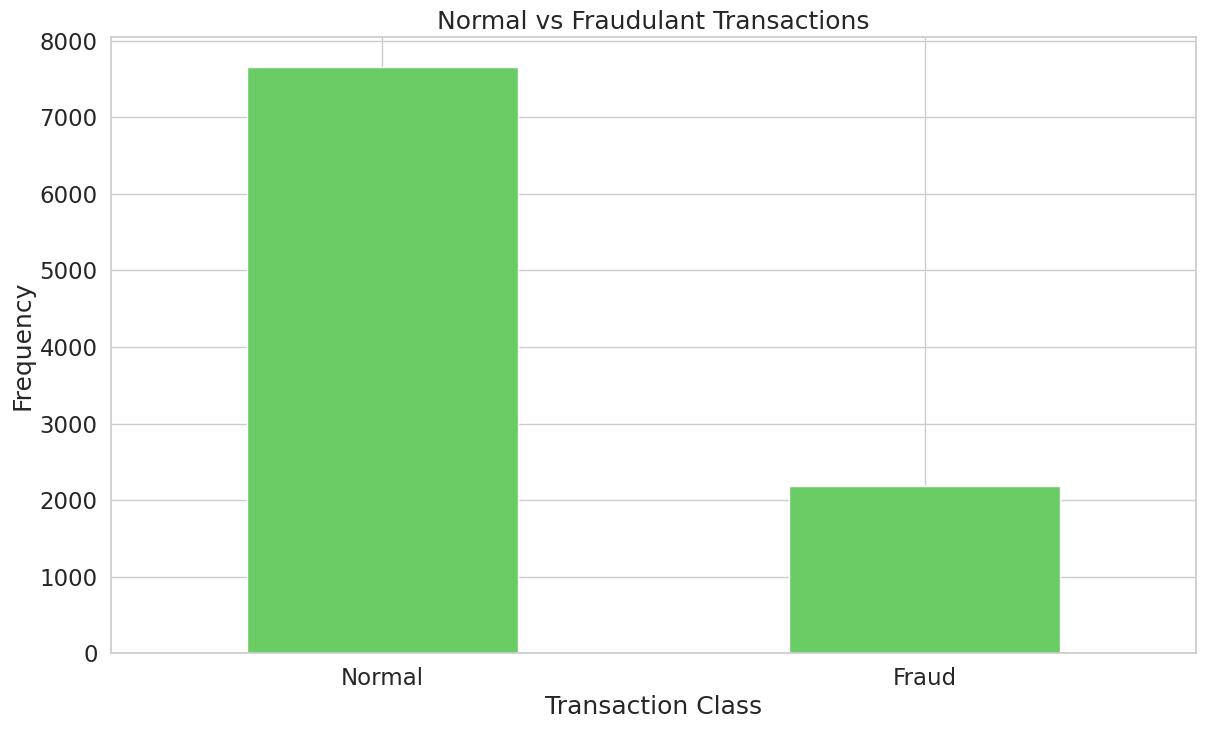

In [34]:
count_classes = pd.value_counts(df['FLAG'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color="g")
plt.title("Normal vs Fraudulant Transactions")
plt.xticks(range(2), LABELS)
plt.xlabel("Transaction Class")
plt.ylabel("Frequency");

Стандартизация

In [35]:
num_col.remove('FLAG')
num_col

['Avg min between sent tnx',
 'Avg min between received tnx',
 'Time Diff between first and last (Mins)',
 'Sent tnx',
 'Received Tnx',
 'Number of Created Contracts',
 'Unique Received From Addresses',
 'Unique Sent To Addresses',
 'min value received',
 'max value received ',
 'avg val received',
 'min val sent',
 'max val sent',
 'avg val sent',
 'min value sent to contract',
 'max val sent to contract',
 'avg value sent to contract',
 'total transactions (including tnx to create contract',
 'total Ether sent',
 'total ether received',
 'total ether sent contracts',
 'total ether balance',
 ' Total ERC20 tnxs',
 ' ERC20 total Ether received',
 ' ERC20 total ether sent',
 ' ERC20 total Ether sent contract',
 ' ERC20 uniq sent addr',
 ' ERC20 uniq rec addr',
 ' ERC20 uniq sent addr.1',
 ' ERC20 uniq rec contract addr',
 ' ERC20 avg time between sent tnx',
 ' ERC20 avg time between rec tnx',
 ' ERC20 avg time between rec 2 tnx',
 ' ERC20 avg time between contract tnx',
 ' ERC20 min val

Разделите набор данных на наборы обучающих и тестовых данных.
Мы разделили набор данных как обучение = 80% и тест = 20%. В обучающем наборе данных будут только обычные транзакции, а в тестовом наборе данных будут как обычные, так и мошеннические транзакции.

In [36]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
# Создание объекта StandardScaler
scaler = StandardScaler()

# Стандартизация только количественных столбцов в тренировочной выборке
X_train[num_col] = scaler.fit_transform(X_train[num_col])

# Применение тех же параметров стандартизации к количественным столбцам тестовой выборки
X_test[num_col] = scaler.transform(X_test[num_col])

X_train = X_train[X_train.FLAG == 0]
X_train = X_train.drop(['FLAG'], axis=1)

y_test = X_test['FLAG']
X_test = X_test.drop(['FLAG'], axis=1)

X_train = X_train.values
X_test = X_test.values
y_test = y_test.values
print(y_test.size)

1969


In [37]:
num_params = X_train.shape[1]

Model


Мы построим автоэнкодер, состоящий из 4 полносвязных слоев с [48(коли-во входных параметров)] - 14 - 7 - 7 - 48 нейронами. Первые 2 слоя действуют как кодировщик, а последние 2 слоя действуют как декодер. Обратите внимание, что последний слой имеет 48 узлов, соответствующих 48 функциям в элементе входных данных.

In [38]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_params, 14),
            nn.Tanh(),
            nn.Linear(14, 7),
            nn.LeakyReLU(),
            )

        self.decoder = nn.Sequential(
           nn.Linear(7, 7),
           nn.Tanh(),
           nn.Linear(7, num_params),
           nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [39]:
model = Autoencoder().double()

In [40]:
num_epochs = 200   # сколько эпох будем обучать. Результаты обучения на одной эпохе используются как начальные для следующей.
minibatch_size = 32
learning_rate = 1e-3

minibatch_size - размер мини-пакета - это количество записей (или векторов), которые мы одновременно передаем в наш алгоритм обучения. Отношение между тем, насколько быстро наш алгоритм может обучить модель, обычно имеет U-образную форму (размер пакета в зависимости от скорости обучения). Это означает, что первоначально по мере увеличения размера партии время обучения будет уменьшаться. В конце концов мы увидим, что время обучения начинает увеличиваться, когда мы превышаем определенный размер пакета, который слишком велик. По мере увеличения размера мини-пакета большее количество вычислений означает, что градиенты могут быть более плавными, но их вычисление требует больших затрат. В идеале каждая мини-партия, на которой проводится обучение, должна содержать пример каждого класса, чтобы уменьшить ошибку выборки при оценке градиента для всей обучающей выборки.

learning_rate - скорость оптимизации (обучения). Насколько маленькими шашами мы изменяем градиент.

In [41]:
train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)

In [42]:
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)

In [43]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=10e-05)

In [44]:
history = {}
history['train_loss'] = []
history['test_loss'] = []

In [45]:
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:

        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)


torch.save(model.state_dict(), './credit_card_model.pth')

epoch [1/200], loss:813.4810
epoch [2/200], loss:804.7677
epoch [3/200], loss:795.1178
epoch [4/200], loss:791.5760
epoch [5/200], loss:778.4298
epoch [6/200], loss:768.2365
epoch [7/200], loss:764.1717
epoch [8/200], loss:753.7112
epoch [9/200], loss:745.9680
epoch [10/200], loss:735.9538
epoch [11/200], loss:731.2178
epoch [12/200], loss:725.0029
epoch [13/200], loss:714.2065
epoch [14/200], loss:708.0701
epoch [15/200], loss:704.0426
epoch [16/200], loss:697.0589
epoch [17/200], loss:689.7343
epoch [18/200], loss:678.9161
epoch [19/200], loss:674.2365
epoch [20/200], loss:669.3443
epoch [21/200], loss:664.5996
epoch [22/200], loss:652.4289
epoch [23/200], loss:646.2579
epoch [24/200], loss:642.2449
epoch [25/200], loss:633.7972
epoch [26/200], loss:629.1363
epoch [27/200], loss:622.8448
epoch [28/200], loss:616.1421
epoch [29/200], loss:611.2190
epoch [30/200], loss:602.1478
epoch [31/200], loss:598.8706
epoch [32/200], loss:591.2658
epoch [33/200], loss:586.5630
epoch [34/200], los

In [46]:
mini = min(history['train_loss'])
maxi = max(history['train_loss'])

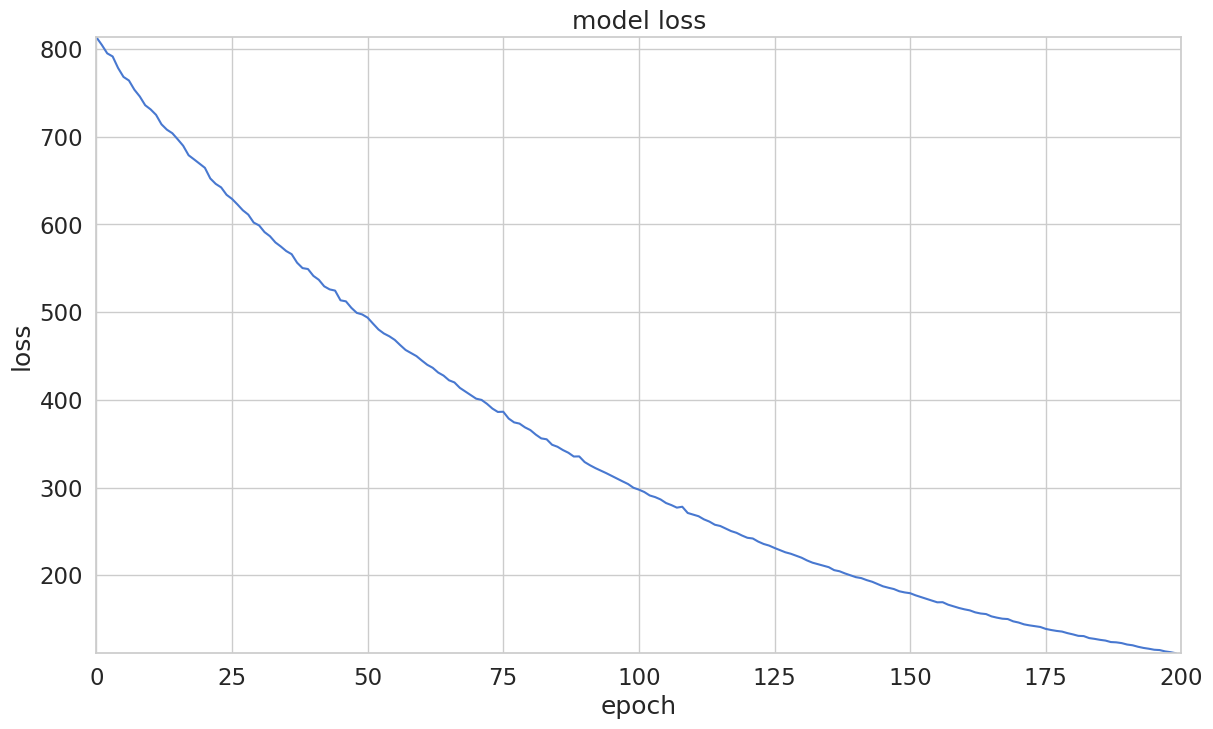

In [47]:
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([0, num_epochs, mini, maxi])
plt.show()

Оценка модели

In [48]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
   # test_loss = 0
    for data in test_loader:
        inputs = data
        # print(inputs)
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        #print(loss)
        pred_losses['pred_loss'].append(loss)
        #pred_losses = model([y_test.size, y_test])
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test

In [49]:
reconstructionErrorDF.describe()

,pred_loss,Class
count,1969.000000,1969.000000
mean,101.823510,0.216861
std,241.836795,0.412212
min,0.008600,0.000000
25%,0.020760,0.000000
50%,0.110372,0.000000
75%,54.716422,0.000000
max,1644.484189,1.000000


In [50]:
reconstructionErrorDF.describe()

,pred_loss,Class
count,1969.000000,1969.000000
mean,101.823510,0.216861
std,241.836795,0.412212
min,0.008600,0.000000
25%,0.020760,0.000000
50%,0.110372,0.000000
75%,54.716422,0.000000
max,1644.484189,1.000000


Reconstruction Errors without Fraud

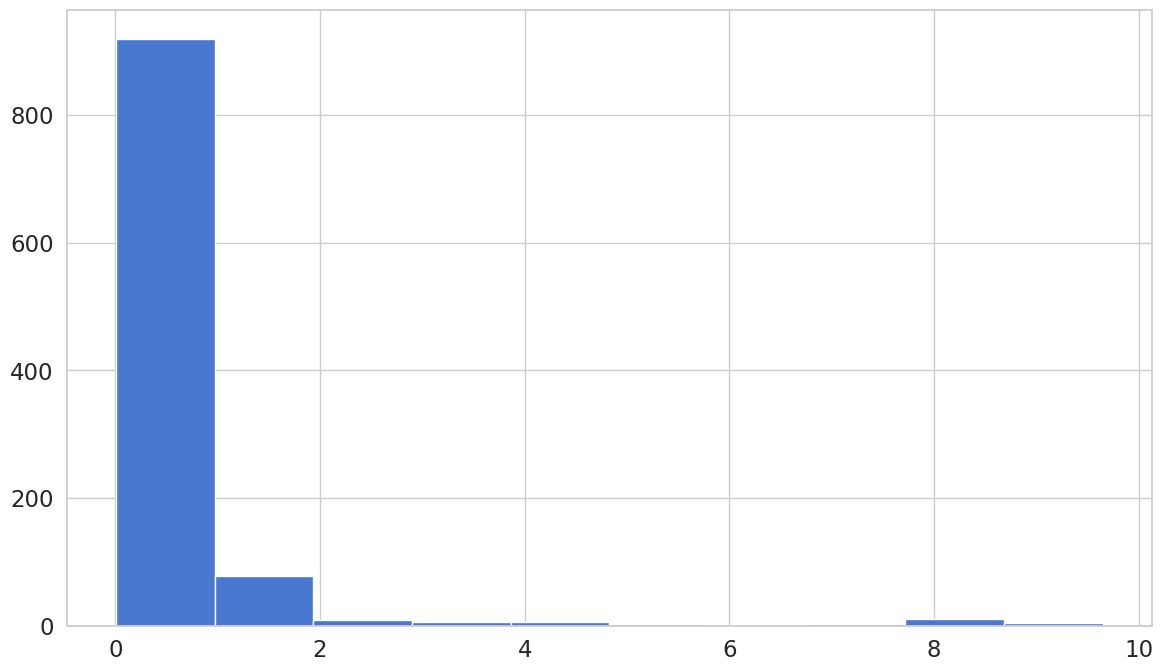

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['Class']== 0) & (reconstructionErrorDF['pred_loss'] < 10)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10)

Reconstruction Errors with Fraud

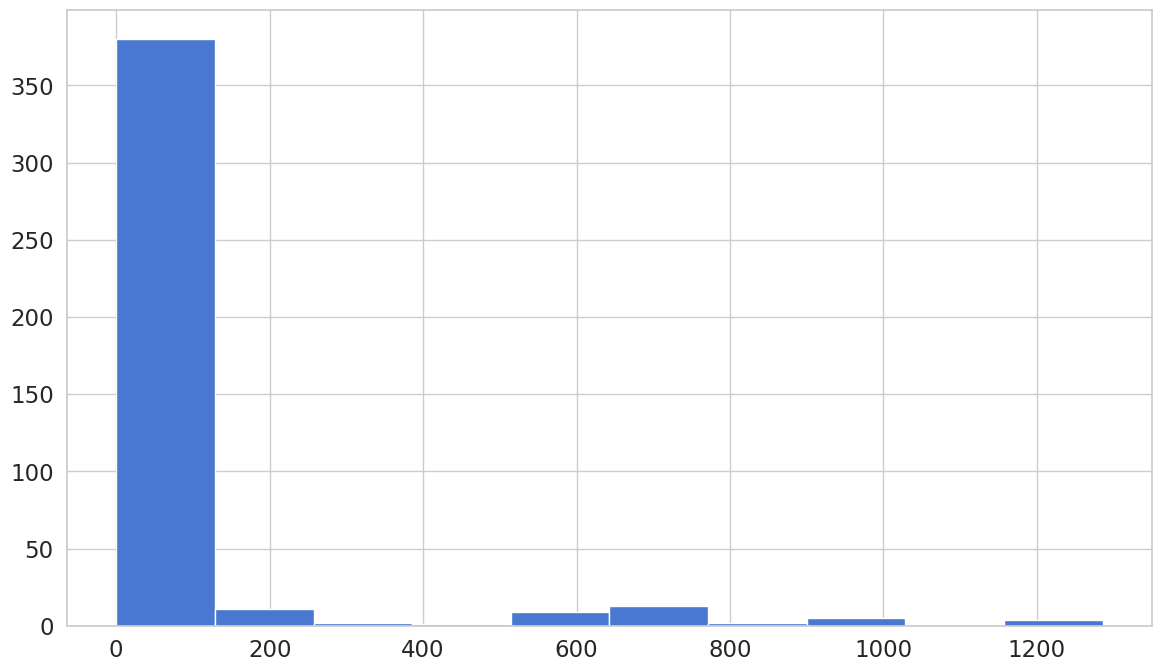

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['Class']== 1) ]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10)

ROC Curves

ROC-кривая очень часто используется для анализа бинарных классификаторов. Он рассматривает все возможные пороговые значения для данного классификатора и показывает процент ложных срабатываний (FPR) по сравнению с показателями истинно положительных результатов (TPR).

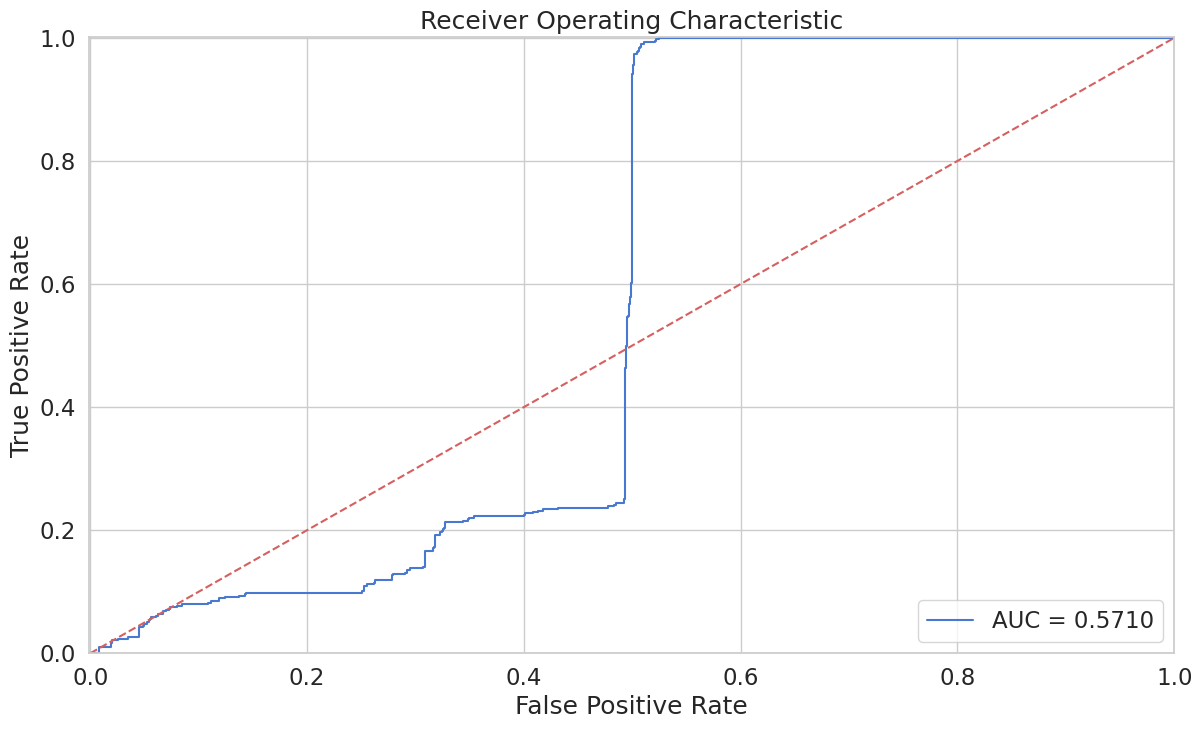

In [53]:
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

Precision vs Recall

Установка порога, который используется для принятия решения о классификации в модели, — это способ настроить компромисс между точностью (precision) и полнотой (recall) для данного классификатора.

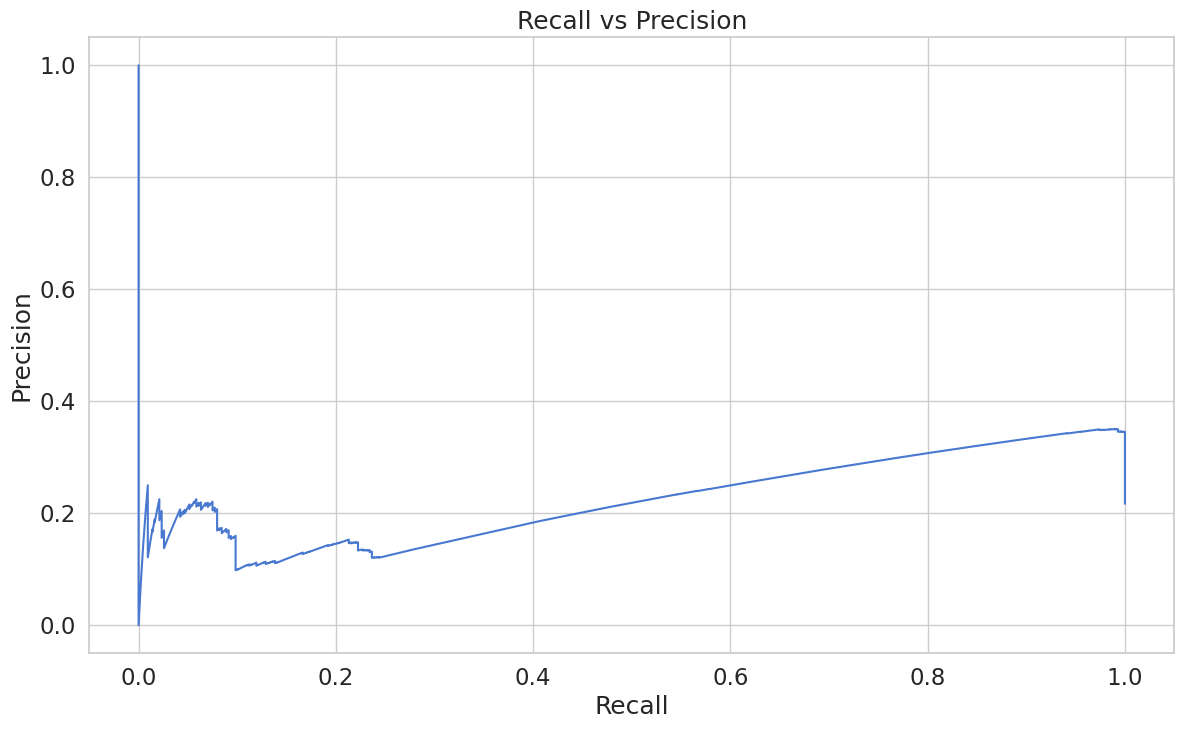

In [54]:
precision, recall, th = precision_recall_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

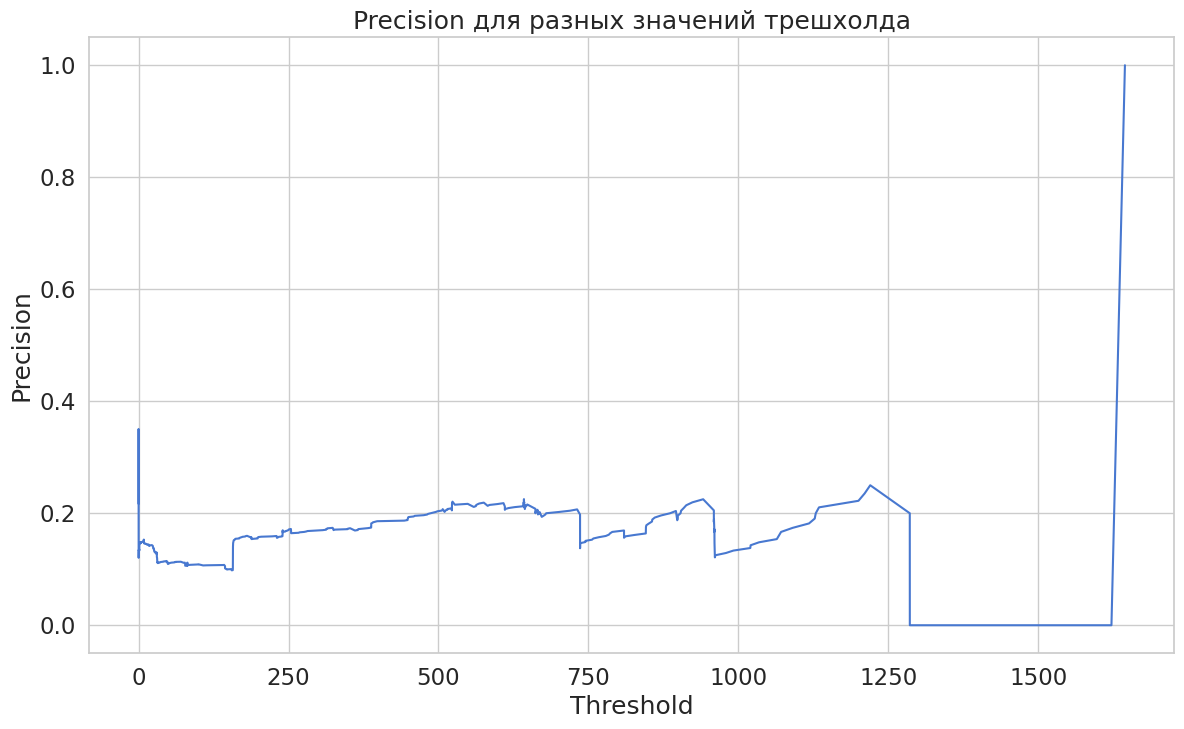

In [55]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision для разных значений трешхолда')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

Вы можете видеть, что по мере увеличения ошибки реконструкции повышается и наша precision. Давайте посмотрим на recall:

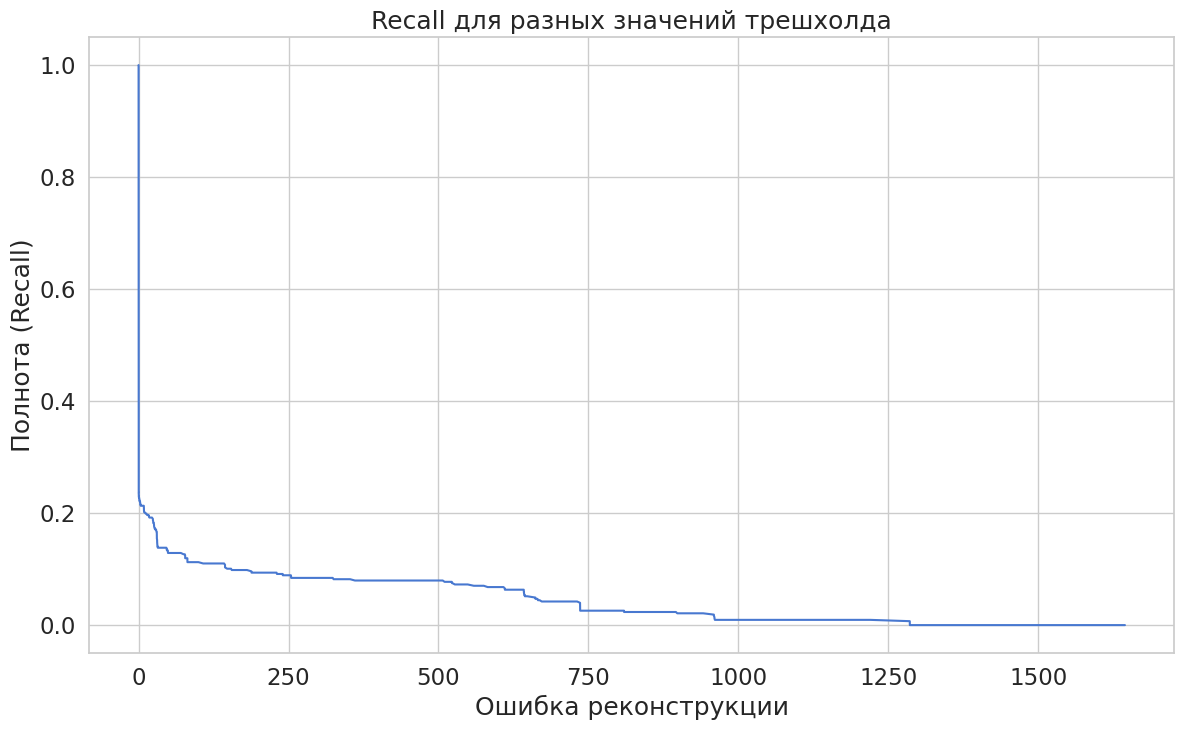

In [56]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall для разных значений трешхолда')
plt.xlabel('Ошибка реконструкции')
plt.ylabel('Полнота (Recall)')
plt.show()

Здесь мы имеем прямо противоположную ситуацию. По мере увеличения ошибки реконструкции recall (полнота) уменьшается.

# Используем модель для того, чтобы сделать предсказание
Чтобы предсказать, является ли новая/невидимая транзакция нормальной или мошеннической, мы рассчитаем ошибку реконструкции на основе самих данных транзакции. Если ошибка превышает предопределенный порог, мы помечаем ее как мошенничество (поскольку наша модель должна иметь низкую ошибку при обычных транзакциях). Давайте выберем это значение:

In [57]:
threshold = 1.63

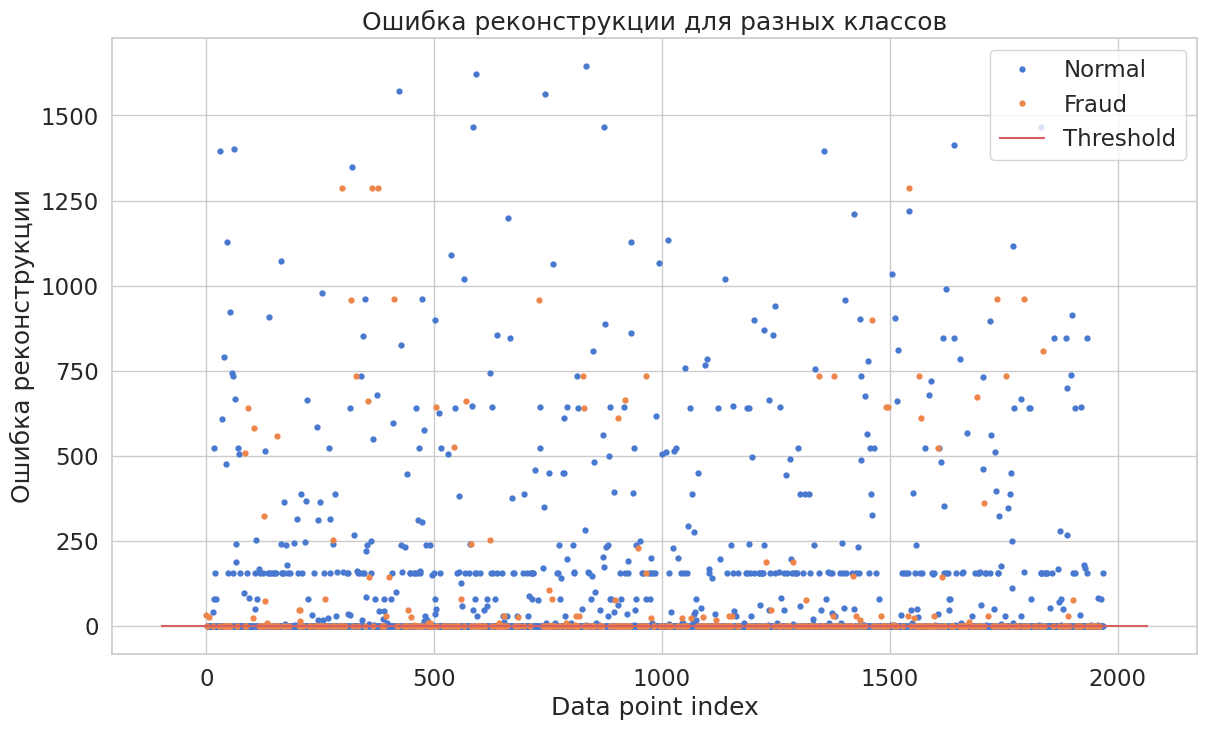

In [58]:
groups = reconstructionErrorDF.groupby('Class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Ошибка реконструкции для разных классов")
plt.ylabel("Ошибка реконструкции")
plt.xlabel("Data point index")
plt.show();

Построим и посмотрим confusion matrix:

<ipython-input-59-11f70cc5c840>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues'));


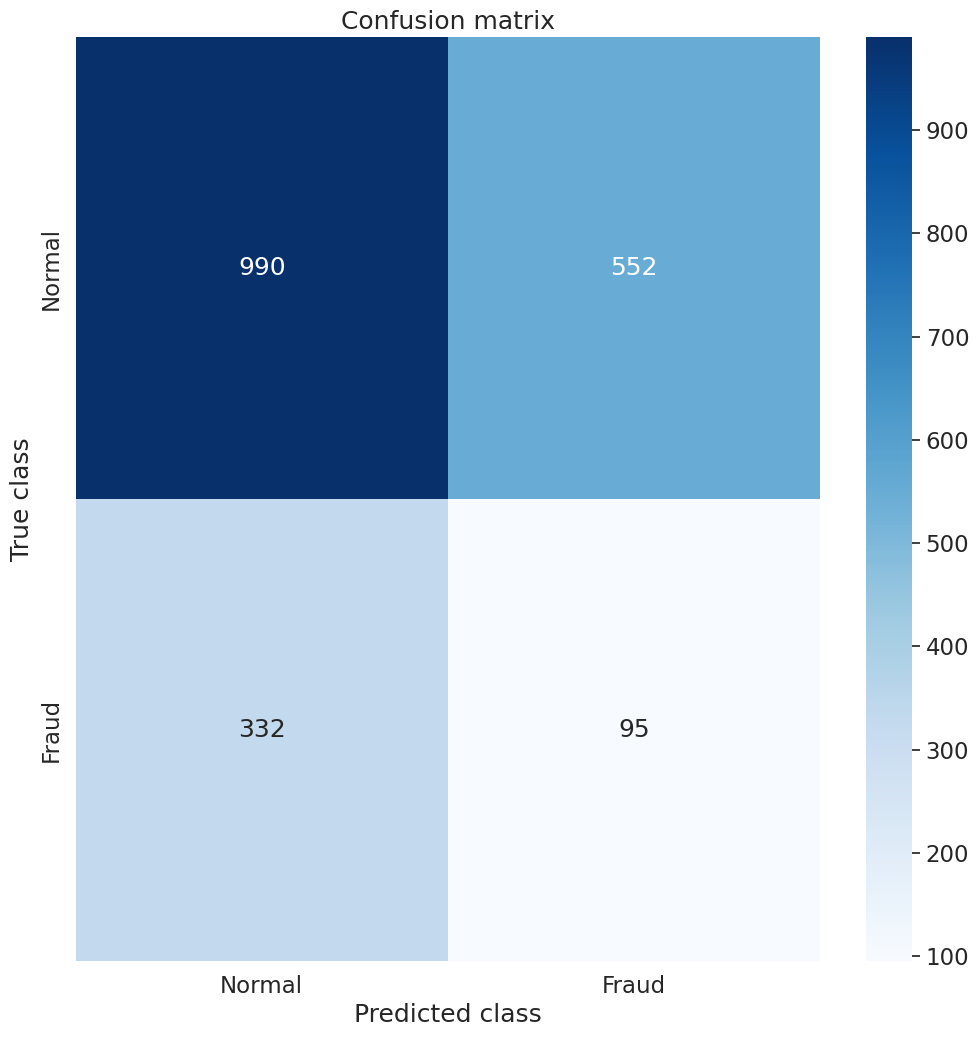

In [59]:
y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF.Class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",
            cmap=plt.cm.get_cmap('Blues'));
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Наша модель, похоже, выявляет множество случаев мошенничества. Но количество обычных транзакций, классифицируемых как мошенничество, действительно велико.

# Выводы
Мы создали очень простой Deep Autoencoder в PyTorch, который может реконструировать, как выглядят немошеннические транзакции. Он научился распознавать немошеннические транзакции, изучая некоторые шаблоны, присутствующие в этих транзакциях, и что это за шаблоны, о которых трудно сказать — загадка любой нейронной сети с глубоким обучением.

PyTorch предоставил нам очень понятный и простой в использовании API для создания нетривиального Deep Autoencoder. Можно попытаться создать аналогичный автоэнкодер, используя другую структуру, например Tensorflow/Keras/fast.ai, для другого домена/проблемы, например, классифицировать изображения как содержащие неприемлемый контент.